In [1]:
import numpy as np
import h5py

from matplotlib.pylab import *
import numpy.linalg as la

import os
from tqdm.notebook import tqdm

path = './data/'

### General Functions

In [2]:
def NumberConnections(Max,a,b): #Compute the ID, number of connections, and the connections
    pbar = tqdm(total = Max, desc = "Computing Connections...")
    ID = np.zeros(Max)
    Nc = np.zeros(Max)
    Connections=[]
    for n in range(Max):
        kx = b[(a == n)]
        ky = a[(b == n)]
        ID[n] = n
        Nc[n] = len(kx)+len(ky)
        Connections.append(np.concatenate( [kx,ky], axis=0))
        pbar.update()
    pbar.close()
    return ID.astype(int), Nc.astype(int), np.array(Connections)

def DP(x1,y1,z1,x2,y2,z2):  #Compute the distance between two points
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

def Eigen(A):# Return the eigenvalues of a Matrix
    w,v=la.eig(A)
    w[(w<0)]=0.0001   # To fix eigenvalues -10**-26
    return w

def Volume(a,b,c):# Compute the volume using the values, a,b,c
    v=a*b*c
    if v<=0:
        v=0.0001  # To fix densisty inf
    return v

def AvD(D):       # Compute the average distance between connections
    if len(D)==0:
        return 0.0001
    else:
        return sum(D)/len(D)

def Features(Max,ID,x,y,z,con): #Return the values of average distance and a,b,c values
    #------------ Nodes
    ad = np.zeros(Max)
    a = np.zeros(Max)
    b = np.zeros(Max)
    c = np.zeros(Max)
    vol = np.zeros(Max)
    den = np.zeros(Max)
    IDnn = ID[nc!=0]
    pbar = tqdm(total=len(IDnn), desc="Computing Features")
    for n in IDnn:
        Ixx = 0
        Iyy = 0
        Izz = 0
        Ixy = 0
        Iyz = 0
        Ixz = 0
        nn = len(con[n])+1
        dist_temp = 0
        for i in con[n]:
            dist_temp = dist_temp+DP(x[n],y[n],z[n],x[i],y[i],z[i])
            Ixx = Ixx+(y[i]-y[n])**2+(z[i]-z[n])**2
            Iyy = Iyy+(z[i]-z[n])**2+(x[i]-x[n])**2
            Izz = Izz+(x[i]-x[n])**2+(y[i]-y[n])**2
            Ixy = Ixy-(x[i]-x[n])*(y[i]-y[n])
            Iyz = Iyz-(y[i]-y[n])*(z[i]-z[n])
            Ixz = Ixz-(x[i]-x[n])*(z[i]-z[n])
        pbar.update(1)
        
        ad[n] = dist_temp/nc[n]
        A = np.array([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz],[Ixz,Iyz,Izz]])
        eig = Eigen(A)
        eig = np.sort(eig)[::-1]# Major -> Minor
        a[n] = np.sqrt(eig[0]).real #.real
        b[n] = np.sqrt(eig[1]).real
        c[n] = np.sqrt(eig[2]).real
        vol[n] = Volume(a[n],b[n],c[n])
        den[n] = 1/vol[n]
    pbar.close()
    return ad,a,b,c,vol,den

def neigh_features(Max,ID,nc,ncn,ad,a,b,c,den,ra,con): #Compute all properties for first neighbors (Gradient)
    nc_n = np.zeros(Max)
    ad_n = np.zeros(Max)
    a_n = np.zeros(Max)
    b_n = np.zeros(Max)
    c_n = np.zeros(Max)
    den_n = np.zeros(Max)
    ra_n = np.zeros(Max)
    IDnn = ID[( nc != 0 )]
    kk = 0
    pbar = tqdm(total = len(IDnn), desc = "Computing Delta Features")
    for i in IDnn:
        nc_temp = 0.0
        ad_temp = 0.0
        a_temp = 0.0
        b_temp = 0.0
        c_temp = 0.0
        den_temp = 0.0
        ra_temp = 0.0
        for j in con[i]:
            nc_temp=nc_temp+ncn[j]
            ad_temp=ad_temp+ad[j]
            a_temp=a_temp+a[j]
            b_temp=b_temp+b[j]
            c_temp=c_temp+c[j]
            den_temp=den_temp+den[j]
            ra_temp=ra_temp+ra[j]
        nc_n[i]=nc_temp/(1.0*nc[i])
        ad_n[i]=ad_temp/(1.0*nc[i])
        a_n[i]=a_temp/(1.0*nc[i])
        b_n[i]=b_temp/(1.0*nc[i])
        c_n[i]=c_temp/(1.0*nc[i])
        den_n[i]=den_temp/(1.0*nc[i])
        ra_n[i]=ra_temp/(1.0*nc[i])
        kk=kk+1
        pbar.update(1)        
    pbar.close()
    nc_n=nc_n-ncn
    ad_n=ad_n-ad
    a_n=a_n-a
    b_n=b_n-b
    c_n=c_n-c
    den_n=den_n-den
    ra_n=ra_n-ra
    return nc_n,ad_n,a_n,b_n,c_n,den_n,ra_n

### Computing the $\beta$-skeleton

In [3]:
#----------------- Reading mock file to extract the r filter magnitud values
filename = path + 'example_mock.hdf5' # lth0.1 because we only need the r_abs that is the same in all mock files
f = h5py.File(filename, 'r')
ra = np.array(f['Mr'])
x = np.array(f['x'])
y = np.array(f['y'])
z = np.array(f['z'])
f.close()

pos_file = "example_pos_mock.txt"
np.savetxt(path + pos_file, np.c_[x,y,z])

#----------------- Computing beta-skeleton with Filipo code
print("Computing BSK for Beta=1.0")
command = 'sh run_BSK.sh '+path+pos_file+' '+pos_file[:-4]+' 1.0'
print (command)
os.system(command)
print("BSK completed! \n "+pos_file[:-4]+".BSKIndex created!")

#----------------- Reading files with beta-skeleton results
betafile = pos_file[:-4]+".BSKIndex"
ca, cb = loadtxt(path+betafile, unpack = True)
x,y,z = loadtxt(path+pos_file, unpack = True)
ca = ca.astype(int)
cb = cb.astype(int)

#----------------- Computing all features form b-skeleton
Max = len(x)
ID,nc,con = NumberConnections(Max,ca,cb)

ad,a,b,c,vol,den = Features(Max,ID,x,y,z,con)

#----------------- New definitons of ad,nc, den
ad = ad/np.mean(ad)    
ncn = nc.astype(float)-np.median(nc.astype(float))
den = np.log(den)

Dnc,Dad,Da,Db,Dc,Dden,Dra = neigh_features(Max,ID,nc,ncn,ad,a,b,c,den,ra,con)

#----------------- Saving all data in a h5 file
f = h5py.File(path+'example_features.h5','w')
dt = h5py.special_dtype(vlen=np.dtype('int64'))
f.create_dataset('con', (len(con),), dtype=dt)
f['con'][...] = con
f.create_dataset('ID', data = ID)
f.create_dataset('coor', data = (x,y,z))
f.create_dataset('nc', data = ncn)
f.create_dataset('ad', data = ad)
f.create_dataset('abc', data = (a,b,c))
f.create_dataset('vol', data = vol)
f.create_dataset('den', data = den)
f.create_dataset('ra', data = ra)
f.create_dataset('Dnc', data = Dnc)
f.create_dataset('Dad', data = Dad)
f.create_dataset('Dabc', data = (Da,Db,Dc))
f.create_dataset('Dden', data = Dden)
f.create_dataset('Dra', data = Dra)
f.close()
print("Created Bsk example_features.h5 file",end="\n\n\n")
print("Catalog creation finished!")

Computing BSK for Beta=1.0
sh run_BSK.sh ./data/example_pos_mock.txt example_pos_mock 1.0
BSK completed! 
 example_pos_mock.BSKIndex created!



Created Bsk example_features.h5 file


Catalog creation finished!


### Plotting the $\beta$-Skeleton

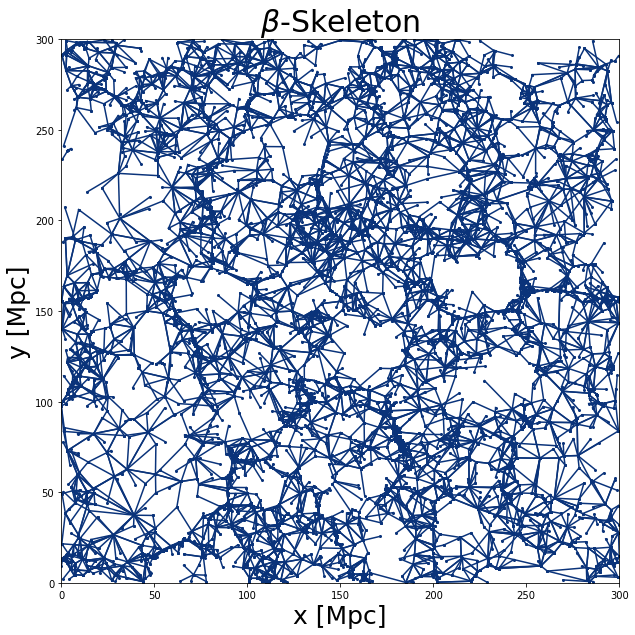

In [4]:
zin = 5
zlim = 40 # Plane in z axis to plot the beta-skeleton
maskzm = z < (zlim + zin)
maskzM = z > (zlim - zin)
IDzm = ID[maskzm & maskzM]

fig = plt.figure(figsize = (10,10))
plt.title(r'$\beta$-Skeleton',size=30)
plt.xlabel("x [Mpc]",size=25)
plt.ylabel("y [Mpc]",size=25)
plt.xlim(0,300)
plt.ylim(0,300)
for k in IDzm:
    for j in con[k]:
        plt.plot([x[k],x[j]],[y[k],y[j]],'bo-',markersize=2, c="#0a337a")